# **Brain Tumor MR Image Classification**

In this model we have constructed the CNN by implementing blocks of sequential layers using Pytorch module.

In [0]:
# Import resources
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import shutil
import torch
import PIL
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#shutil.rmtree('./train')
#shutil.rmtree('./valid')

Import the data from MRI_data.zip



Here the data is provided in two folders namely 'Train' and 'Valid' which specifies training and test set of images. These two folders contain two subfolders namely 'Yes' and 'No' specifying whether the brain images have tumor or not.

In [0]:
!unzip -qq MRI_data.zip

Sample Brain MR Image with Tumor

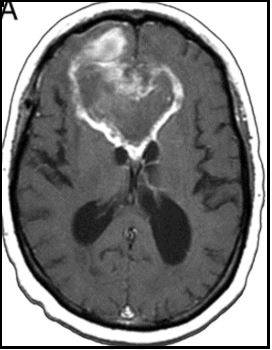

In [0]:
PIL.Image.open('./valid/yes/Y167.JPG')

Sample Brain MR Image without Tumor

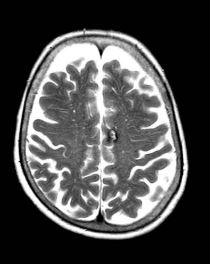

In [0]:
PIL.Image.open('./train/no/N26.JPG')

 Distribution of Classes in Brain Images

[Text(0, 0.5, 'Image Count'), Text(0.5, 0, 'Image Classes')]

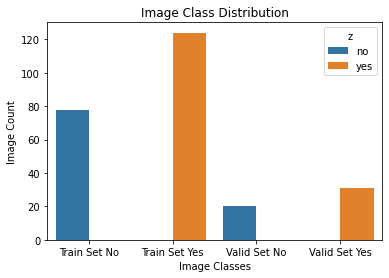

In [0]:
def fcount(path):
    #Counts the number of files in a directory
    count = 0
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)):
            count += 1
    return count

path_tr_no = r"./train/no"
path_tr_yes = r"./train/yes"
path_va_no = r"./valid/no"
path_va_yes = r"./valid/yes"

tr_no = fcount(path_tr_no)
tr_yes = fcount(path_tr_yes)
va_no = fcount(path_va_no)
va_yes= fcount(path_va_yes)

df = pd.DataFrame() 
cnt_data = {'x':['Train Set No','Train Set Yes' ,'Valid Set No','Valid Set Yes'], 
            'y':[tr_no,tr_yes,va_no,va_yes],
            'z':['no','yes','no','yes']}
df = pd.DataFrame(cnt_data) 

ax=sns.barplot(x='x',y='y',hue='z',data=df)
ax.set_title("Image Class Distribution")
ax.set(xlabel="Image Classes", ylabel = "Image Count")

# Image Preprocessing

Step 1: Cropping the Images along the contours and Gaussian Blurring

In [0]:
# Cropping the contours in the brain images
def load_edge_crop(filename):

    images = list()
    for fname in os.listdir(filename):
        img = cv2.imread(filename + '/' + fname,0)
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
        new_img = cv2.resize(new_img,dsize=(32,32))
        images.append(new_img)

    shutil.rmtree(filename)
    os.mkdir(filename)

    for index,img in enumerate(images):
        cv2.imwrite(filename + '/' + str(index) + '.jpg',img)


load_edge_crop('./train/no')
load_edge_crop('./train/yes')
load_edge_crop('./valid/no')
load_edge_crop('./valid/yes')

Step 2: Data transformation such as image rotation and flipping, conversion of images into tensors

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() ]),

    'valid': transforms.Compose([
        transforms.ToTensor() ])
}

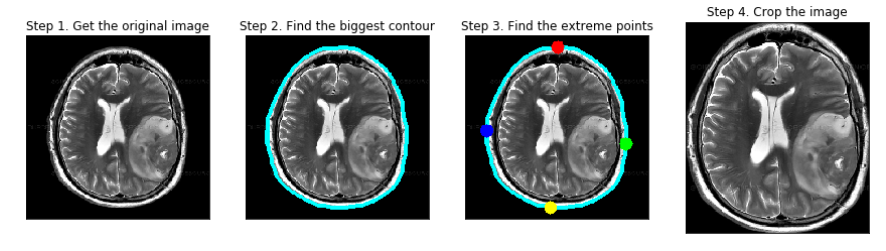

Loading the images into dataloaders as trainloaders and testloaders for training

In [0]:
data = {x: datasets.ImageFolder(os.path.join("",x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
  
dataloaders = {
    'train': torch.utils.data.DataLoader(data['train'], batch_size=4, shuffle=True),
    'valid': torch.utils.data.DataLoader(data['valid'], batch_size=1, shuffle=True)
}

Checking dataset sizes and classses

In [0]:
dataset_sizes = {x: len(data[x]) for x in ['train', 'valid']}
data_path = './train'
classes = os.listdir(data_path)
classes.sort()

print(dataset_sizes)
print(len(classes), 'classes:')
print(classes)

{'train': 202, 'valid': 51}
2 classes:
['no', 'yes']


Checking the input shape of train images in trainloader

In [0]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

Checking the input shape of test images in testloader

In [0]:
validiter = iter(dataloaders['valid'])
features,labels=next(validiter)
features.shape,labels.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1]))

Model Building- Convolutional Neural Network in Pytorch

In [0]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        
        #spatial size=(32,32)
        self.cnn1 = nn.Conv2d(3,16,kernel_size=(9,9),padding=4)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.act = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.45)

        #spatial size=(16,16)
        self.cnn2 = nn.Conv2d(16,16,kernel_size=(9,9),padding=4)
        self.bnorm2 = nn.BatchNorm2d(16)
        self.act = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        #spatial size=(8,8)
        self.cnn3 = nn.Conv2d(16,36,kernel_size=(9,9),padding=4)
        self.act = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.25)
        
        #spatial size=(4,4)
        self.fc1 = nn.Linear(in_features=36 * 4 * 4, out_features=512)
        self.drop4 = nn.Dropout(0.15)
        self.fc2 = nn.Linear(512,2)
        

    def forward(self, x):
        x = self.act(self.cnn1(x))
        x = self.bnorm1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.act(self.cnn2(x))
        x = self.bnorm2(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = self.act(self.cnn3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = x.view(-1,36*4*4)
        x = F.relu(self.fc1(x))
        x = self.drop4(x)
        x = x.view(-1,512)
        x = torch.sigmoid(self.fc2(x))

        return x

# Calling the model        
net = Net()

Specifying Optimizer and Loss Functions

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training the model with train data

In [0]:
for epoch in range(50):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'],0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
         
print('Finished Training')

Finished Training


Testing the model and calculating the accuracy and loss

In [0]:
testloader=dataloaders['valid']
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)
        output = net(data)
            
        test_loss += criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy=100. * correct / len(testloader.dataset)
        
print('Test set: Average loss: {:.4f}\nAccuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(testloader.dataset),
        accuracy))

Test set: Average loss: 23.5554
Accuracy: 44/51 (86%)


Model Performance

In [0]:
# printing accuracy and loss for each value in train set
acc_train=[]
loss_train=[]
pred_train=[]
trainloader=dataloaders['train']
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in (trainloader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        test_loss = criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1] 
        pred_train.append(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy=100. * correct / len(trainloader.dataset)
        acc_train.append(accuracy)
        loss_train.append(test_loss)
epoch_count=range(1,52)

# printing accuracy and loss for each value in validation set
acc_valid=[]
loss_valid=[]
pred_valid=[]
testloader=dataloaders['valid']
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)
        output = net(data)

        test_loss = criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1] 
        pred_valid.append(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy=100. * correct / len(testloader.dataset)
        acc_valid.append(accuracy)
        loss_valid.append(test_loss)
epoch_count2=range(1,52)

In [0]:
#pickle.dump(net,open('NN.sav', 'wb'))

Accuracy Comparison of Train and Validation Image

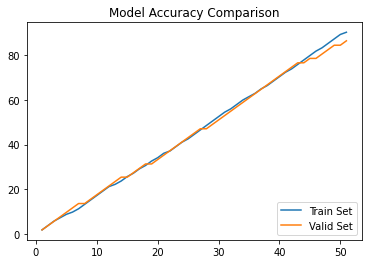

In [0]:
plt.plot(epoch_count, acc_train, label='Train Set')
plt.title("Model Accuracy Comparison")
plt.plot(epoch_count2, acc_valid, label='Valid Set')
plt.legend(loc='lower right')


Loss Comparison of Train and Validation Image

Text(0.5, 1.0, 'Model Loss Comparison')

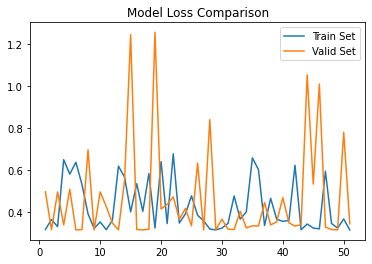

In [0]:
plt.plot(epoch_count, loss_train, label='Train Set')
plt.plot(epoch_count2, loss_valid, label='Valid Set')
plt.legend(loc='best')
plt.title("Model Loss Comparison")

Confusion Matrix

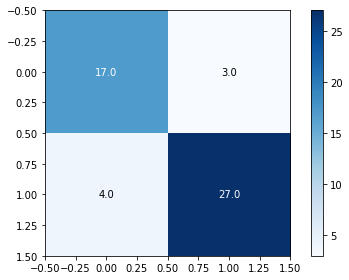

In [0]:
nb_classes = 2   
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, target) in enumerate(dataloaders['valid']):

        inputs = inputs.to(device)
        target = target.to(device)

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

num_classes = 2
class_names = classes                

plt.figure()
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

tick_marks = np.arange(num_classes)
classNames = class_names

thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j]),
                ha="center", va="center",
                color="white" if  confusion_matrix[i, j] == 0 or confusion_matrix[i, j] > thresh else "black") 
plt.tight_layout()
plt.colorbar()
plt.show()